In [2]:
import random
import pandas as pd
import numpy as np

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from numpy.random import randn
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier


In [3]:
# Generate real data

n_samples=1000
n_vars=8
data = pd.DataFrame(np.random.normal(size=(n_samples, n_vars)))


In [4]:
def generate_latent_points(latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)    
    return x_input

In [5]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    x_input = generate_latent_points(latent_dim, n_samples)
    X = generator.predict(x_input)
    y = np.zeros((n_samples, 1))
    
    return X, y

In [6]:
# generate n real samples with class labels; We randomly select n samples from the real data
def generate_real_samples(n):
    X = data.sample(n)
    y = np.ones((n, 1))    
    return X, y

In [7]:
def define_generator(latent_dim, n_outputs=8):
    model = Sequential()
    model.add(Dense(15, activation='relu',  kernel_initializer='he_uniform', input_dim=latent_dim))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(n_outputs, activation='linear'))    
    return model

In [8]:
generator1 = define_generator(10, 8)
generator1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 15)                165       
                                                                 
 dense_1 (Dense)             (None, 30)                480       
                                                                 
 dense_2 (Dense)             (None, 8)                 248       
                                                                 
Total params: 893
Trainable params: 893
Non-trainable params: 0
_________________________________________________________________


In [9]:
def define_discriminator(n_inputs=8):
    model = Sequential()
    model.add(Dense(25, activation='relu', kernel_initializer='he_uniform', input_dim=n_inputs))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [10]:
discriminator1 = define_discriminator(8)
discriminator1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 25)                225       
                                                                 
 dense_4 (Dense)             (None, 50)                1300      
                                                                 
 dense_5 (Dense)             (None, 1)                 51        
                                                                 
Total params: 1,576
Trainable params: 1,576
Non-trainable params: 0
_________________________________________________________________


In [11]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
    # make weights in the discriminator not trainable
    discriminator.trainable = False    
    model = Sequential()    # add generator
    model.add(generator)    # add the discriminator
    model.add(discriminator)    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam')    
    return model

In [12]:
# create a line plot of loss for the gan and save to file
def plot_history(d_hist, g_hist):
    # plot loss
    plt.subplot(1, 1, 1)
    plt.plot(d_hist, label='d')
    plt.plot(g_hist, label='gen')
    plt.show()
    plt.close()

In [15]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, n_epochs=10000, n_batch=128):

  
  # determine half the size of one batch, for updating the discriminator
  half_batch = int(n_batch / 2)

  d_history = []
  g_history = []
  
  # manually enumerate epochs
  for epoch in range(n_epochs):

    # prepare real samples
    x_real, y_real = generate_real_samples(half_batch)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
    # update discriminator
    d_loss_real, d_real_acc = d_model.train_on_batch(x_real, y_real)
    d_loss_fake, d_fake_acc = d_model.train_on_batch(x_fake, y_fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    
    # prepare points in latent space as input for the generator
    x_gan = generate_latent_points(latent_dim, n_batch)
    
    # create inverted labels for the fake samples
    y_gan = np.ones((n_batch, 1))
    
    # update the generator via the discriminator's error
    g_loss_fake = gan_model.train_on_batch(x_gan, y_gan)

    print('>%d, d1=%.3f, d2=%.3f d=%.3f g=%.3f' % (epoch+1, d_loss_real, d_loss_fake, d_loss,  g_loss_fake))
    d_history.append(d_loss)
    g_history.append(g_loss_fake)

  plot_history(d_history, g_history)

    # if i==999:
    #   np.savetxt("new_X.csv", X, delimiter=",")
    
    # evaluate the model every n_eval epochs
    # if (i+1) % n_eval == 0:
    #   summarize_performance(i, g_model, d_model, latent_dim)
  g_model.save('trained_generated_model_20210205_v3.h5')
  

2/2 [==============================] - 0s 5ms/step


Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 5ms/step
>7501, d1=0.659, d2=0.458 d=0.559 g=1.218
2/2 [==============================] - 0s 3ms/step
>7502, d1=0.618, d2=0.586 d=0.602 g=1.174
2/2 [==============================] - 0s 3ms/step
>7503, d1=0.630, d2=0.452 d=0.541 g=1.320
2/2 [==============================] - 0s 5ms/step
>7504, d1=0.482, d2=0.486 d=0.484 g=1.283
2/2 [==============================] - 0s 3ms/step
>7505, d1=0.571, d2=0.495 d=0.533 g=1.348
2/2 [==============================] - 0s 4ms/step
>7506, d1=0.517, d2=0.481 d=0.499 g=1.184
2/2 [==============================] - 0s 3ms/step
>7507, d1=0.504, d2=0.487 d=0.496 g=1.191
2/2 [==============================] - 0s 5ms/step
>7508, d1=0.471, d2=0.539 d=0.505 g=1.339
2/2 [==============================] - 0s 3ms/step
>7509, d1=0.525, d2=0.471 d=0.498 g=1.355
2/2 [==============================] - 0s 10ms/step
>7510, d1=0.583, d2=0.484 d=0.533 g=1.245
2/2 [=============

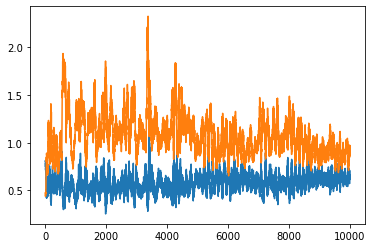

In [16]:
# size of the latent space
latent_dim = 10# create the discriminator
discriminator = define_discriminator()# create the generator
generator = define_generator(latent_dim)# create the gan
gan_model = define_gan(generator, discriminator)# train model
train(generator, discriminator, gan_model, latent_dim)

In [18]:
from keras.models import load_model
model =load_model('/content/trained_generated_model_20210205_v3.h5')

In [19]:
latent_points = generate_latent_points(10, 750)
X = model.predict(latent_points)

24/24 [==============================] - 0s 7ms/step


In [20]:
data_fake = pd.DataFrame(data=X)
data_fake.head()

,0,1,2,3,4,5,6,7
0,0.089252,-0.920850,1.302191,1.019706,-0.893275,1.227046,-0.156036,-0.536825
1,2.017832,-0.495540,0.850871,1.491992,0.157528,0.310491,-0.615877,-0.072905
2,0.714370,-0.135967,0.495407,0.823533,0.021497,-0.120594,0.952494,0.013372
3,-1.884674,-0.459450,2.334101,-0.423027,1.319547,1.332571,0.700055,0.024861
4,-0.895717,-0.153740,1.119414,-0.842132,0.350321,1.402831,1.376366,0.016495


In [21]:
!pip install table_evaluator

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.0/285.0 KB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 97.1 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of table-evaluator to determine which version is compatible with other requirements. This could take a while.
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.11.2
    Uninstalling seaborn-0.11.2:
      Successfully uninstalled seaborn-0.11.2


In [23]:
from table_evaluator import load_data, TableEvaluator
#table_evaluator = TableEvaluator(data, data_fake)
#table_evaluator.evaluate(target_col='Outcome')

In [24]:
table_evaluator = TableEvaluator(data, data_fake)
#table_evaluator.evaluate(target_col='Outcome')

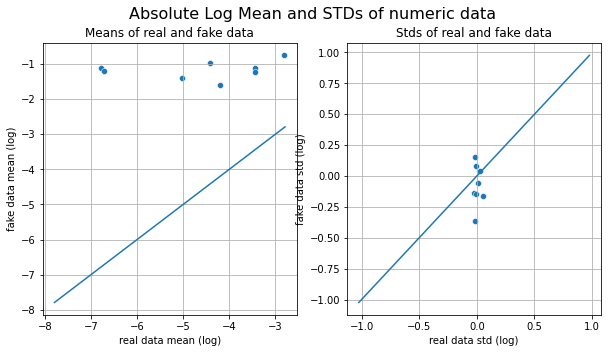

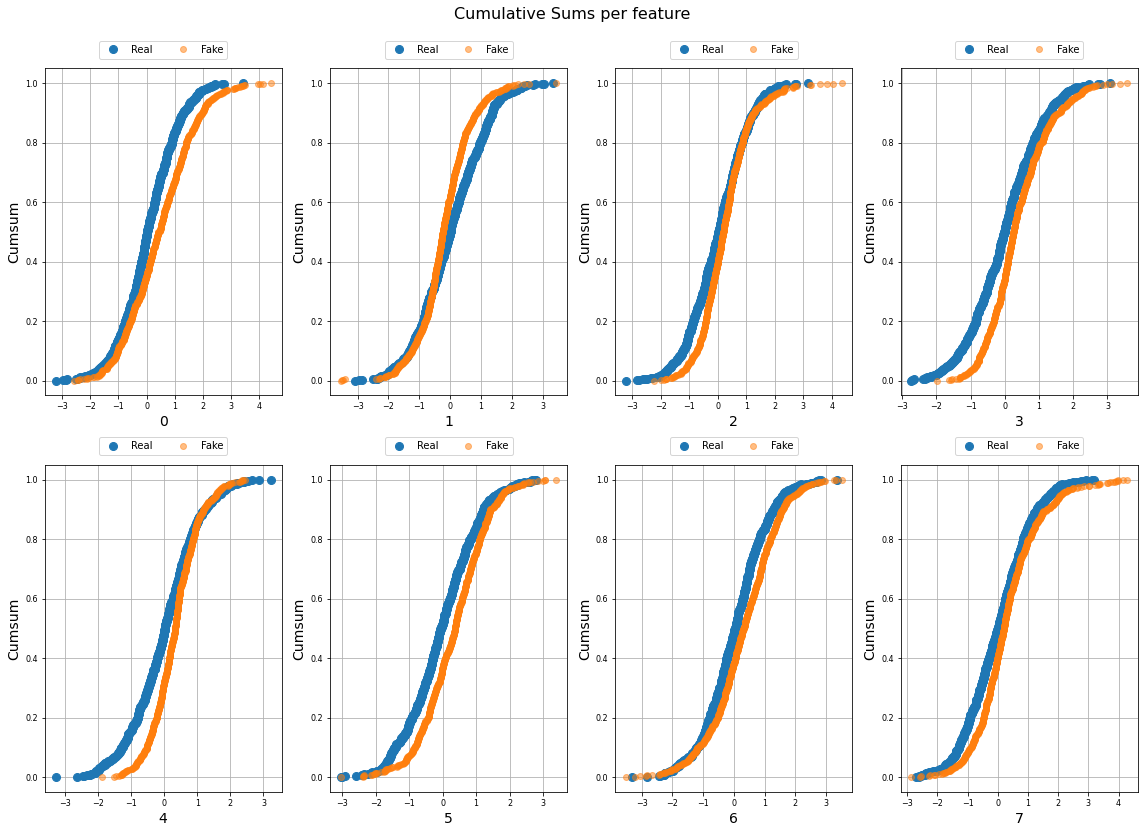

/usr/local/lib/python3.9/dist-packages/table_evaluator/table_evaluator.py:156: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  plot_df = pd.DataFrame({col: self.real[col].append(self.fake[col]), 'kind': ['real'] * self.n_samples + ['fake'] * self.n_samples})
/usr/local/lib/python3.9/dist-packages/table_evaluator/table_evaluator.py:156: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  plot_df = pd.DataFrame({col: self.real[col].append(self.fake[col]), 'kind': ['real'] * self.n_samples + ['fake'] * self.n_samples})
/usr/local/lib/python3.9/dist-packages/table_evaluator/table_evaluator.py:156: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  plot_df = pd.DataFrame({col: self.real[col].append(self.fake[col]), 'kind': ['real'] * self

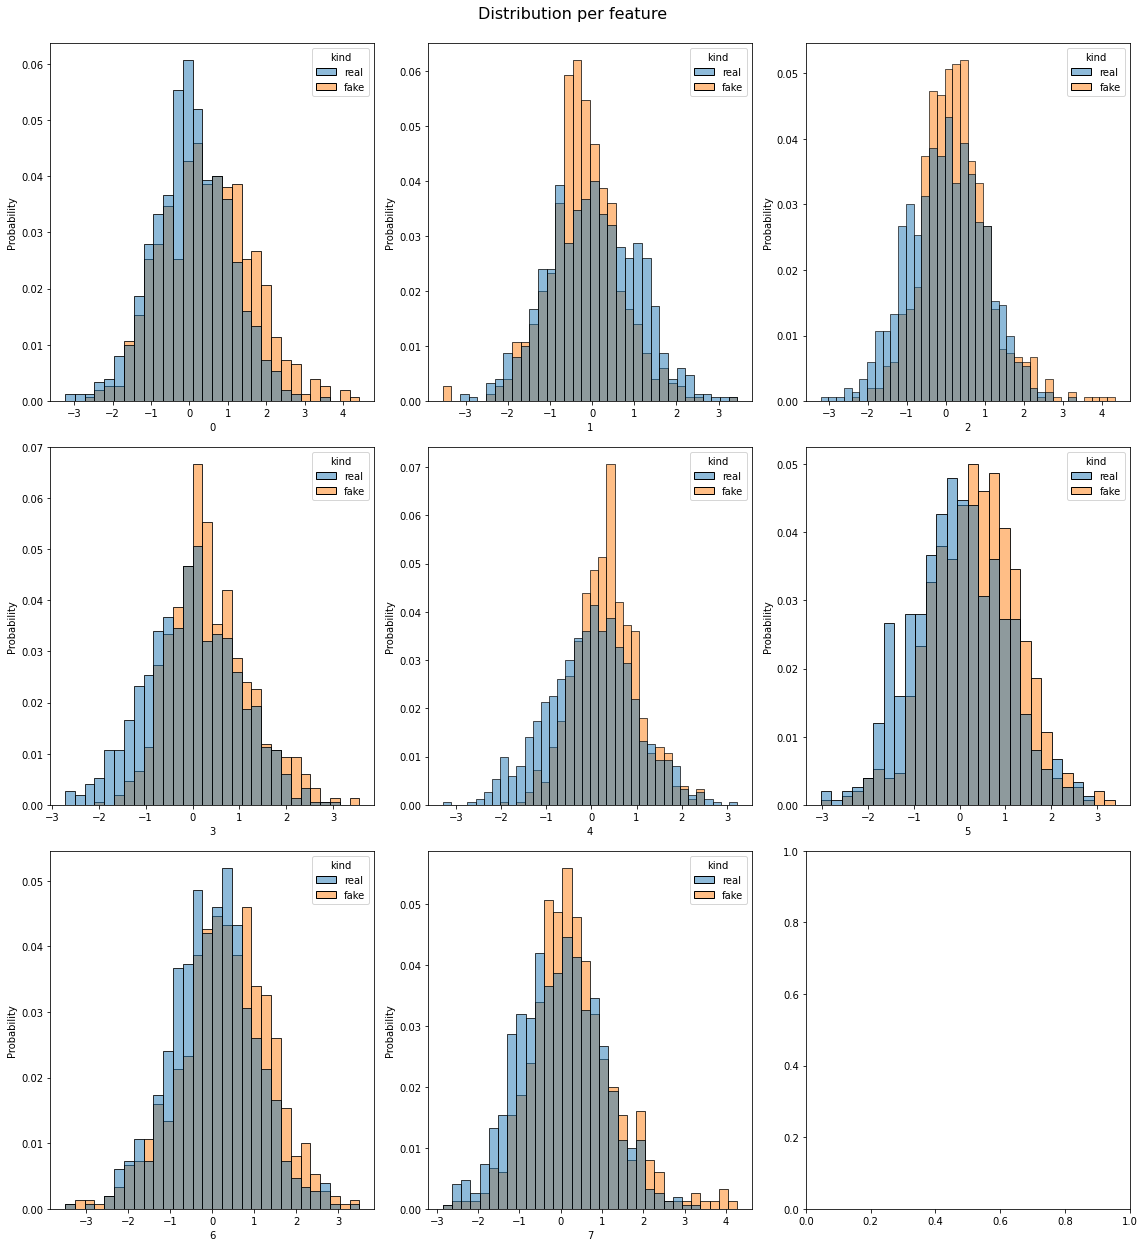

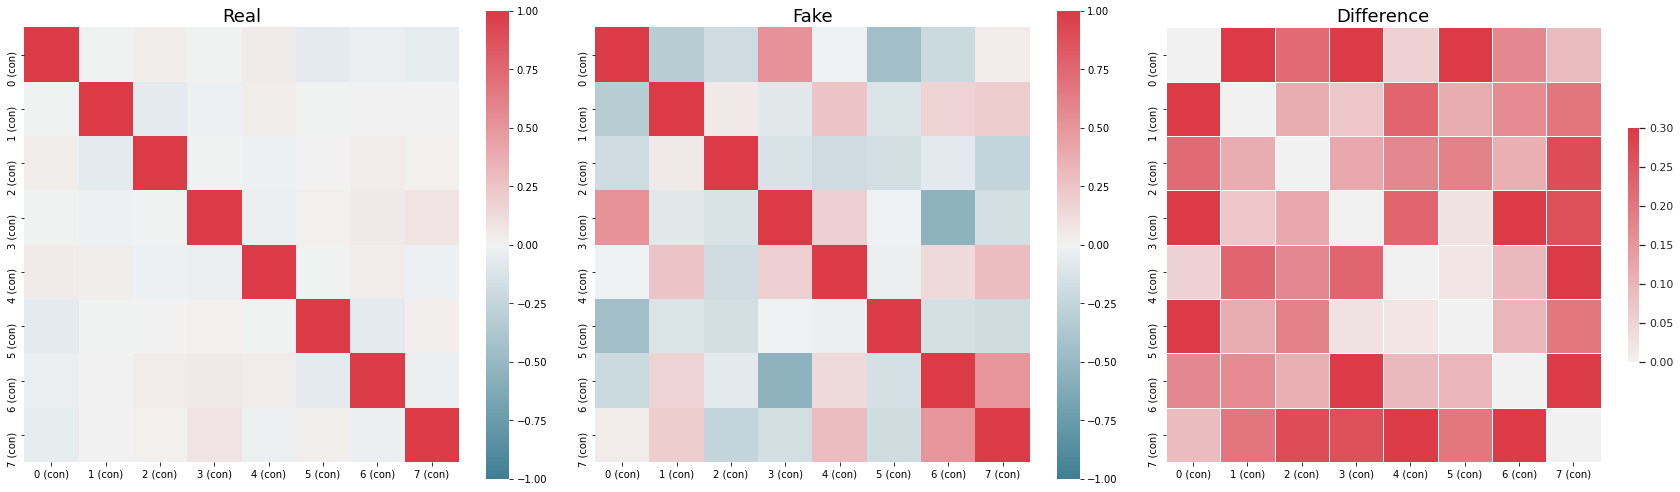

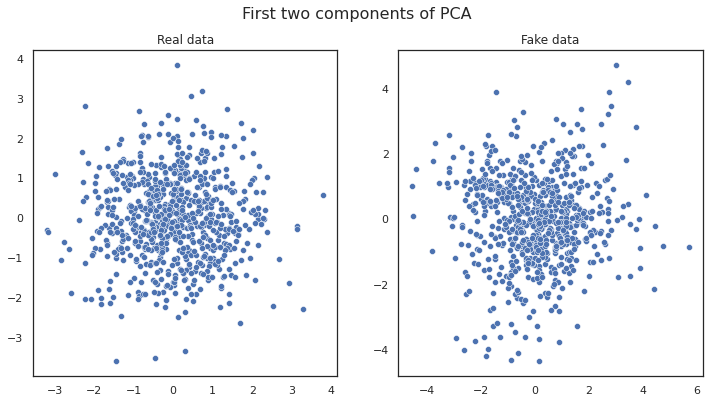

In [26]:
table_evaluator.visual_evaluation()

In [27]:
data.to_csv("Real_data.csv")#, data_fake

In [28]:
data_fake.to_csv("Generated_fake_data.csv")